In [ ]:
%load_ext autoreload
%autoreload 2


# Deep Learning Analysis

In [1]:
import json
import joblib
import lightning as L
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchmetrics import MeanSquaredError
from torchvision import datasets
from utils.helper_classes import CancerDataModule, CancerDataset
from utils.models import BaseCancerRegressor, CancerDataAutoEncoder

In [2]:
cancer_df = pd.read_csv("../data/cleaned_feature_and_target_data.csv", index_col=0)
cna_columns = [col for col in cancer_df.columns if col.startswith("CNA")]
numeric_cols = ["SMOKING_PACK_YEARS"] + cna_columns
cancer_df[numeric_cols] = cancer_df[numeric_cols].astype(np.float32)
scaler = joblib.load(open("results/scaler.pkl", "rb"))
cancer_dm = CancerDataModule(cancer_df, numerical_features=numeric_cols, scaler=scaler)
cancer_dm.setup()

In [3]:
import random


class NNRegressor(L.LightningModule):
    def __init__(self, input_dim, n_layers=1, dropout=0.2, activation=nn.LeakyReLU, optimizer=torch.optim.Adam, lr=1e-3, weight_decay=1e-4):
        super(NNRegressor, self).__init__()
        self.optimizer = optimizer
        self.lr = lr
        self.weight_decay = weight_decay
        self.layers = []
        curr_size = input_dim
        len_first_half = int(n_layers / 2)
        len_second_half = n_layers - len_first_half
        for i in range(len_first_half):
            new_size = curr_size * 2
            self.layers += [
                nn.Linear(curr_size, new_size),
                nn.BatchNorm1d(new_size),
                activation(),
                nn.Dropout(dropout),
            ]
            curr_size = new_size
        
        for i in range(len_second_half):
            new_size = curr_size // 2
            self.layers += [
                nn.Linear(curr_size, new_size),
                nn.BatchNorm1d(new_size),
                activation(),
                nn.Dropout(dropout),
            ]
            curr_size = new_size
        if curr_size > 1:
            self.layers.append(nn.Linear(curr_size, 1))
        self.network = nn.Sequential(*self.layers)

        self.loss_metric = MeanSquaredError()
        self.val_metric = MeanSquaredError()
        self.test_metric = MeanSquaredError()



    def forward(self, x):
        y = self.network(x)
        return y
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        x = x.to(self.device)
        y = y.to(self.device)
        y_hat = self(x)
        loss = nn.functional.mse_loss(y_hat, y)
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_mse", self.loss_metric(y_hat, y), prog_bar=True)

        return loss
    
    def on_training_epoch_end(self):
        self.log("train_mse", self.loss_metric.compute())
        self.loss_metric.reset()

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.functional.mse_loss(y_hat, y)
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_mse", self.val_metric(y_hat, y), prog_bar=True)

    def on_validation_epoch_end(self):
        self.log("val_mse", self.val_metric.compute())
        self.val_metric.reset()
        
    def configure_optimizers(self):
        return self.optimizer(self.network.parameters(), lr=self.lr, weight_decay=self.weight_decay)
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.functional.mse_loss(y_hat, y)
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_mse", self.test_metric(y_hat, y), prog_bar=True)
        return loss
    
    def on_test_epoch_end(self):
        self.log("test_mse", self.test_metric.compute())
        self.test_metric.reset()

simple_nn = NNRegressor(
    input_dim=len(cancer_dm.ds_train[0][0]),
    n_layers=8
)

In [4]:
from torchinfo import summary

input_dim = len(cancer_dm.ds_train[0][0])
summary(NNRegressor(
    input_dim=len(cancer_dm.ds_train[0][0]),
    n_layers=8
), input_size=(1, input_dim))

Layer (type:depth-idx)                   Output Shape              Param #
NNRegressor                              [1, 1]                    --
├─Sequential: 1-1                        [1, 1]                    --
│    └─Linear: 2-1                       [1, 406]                  82,824
│    └─BatchNorm1d: 2-2                  [1, 406]                  812
│    └─LeakyReLU: 2-3                    [1, 406]                  --
│    └─Dropout: 2-4                      [1, 406]                  --
│    └─Linear: 2-5                       [1, 812]                  330,484
│    └─BatchNorm1d: 2-6                  [1, 812]                  1,624
│    └─LeakyReLU: 2-7                    [1, 812]                  --
│    └─Dropout: 2-8                      [1, 812]                  --
│    └─Linear: 2-9                       [1, 1624]                 1,320,312
│    └─BatchNorm1d: 2-10                 [1, 1624]                 3,248
│    └─LeakyReLU: 2-11                   [1, 1624]            

In [5]:
from utils.helper_functions import create_classifier_trainer

trainer, regressor_csv_logger, regressor_checkpoint = create_classifier_trainer("cancer_regressor")
cancer_regressor = NNRegressor(
    input_dim=len(cancer_dm.ds_train[0][0]),
    n_layers=8
)
trainer.fit(
    cancer_regressor,
    datamodule=CancerDataModule(cancer_df, numerical_features=numeric_cols, scaler=scaler),
)

/uufs/chpc.utah.edu/common/home/clementm-group1/conda/mambaforge/env/bmi_6114/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /uufs/chpc.utah.edu/common/home/clementm-group1/cond ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | network     | Sequential       | 14.0 M | train
1 | loss_metric | MeanSquaredError | 0      | train
2 | val_metric  | MeanSquaredError | 0      | train
3 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
14.0 M    Trainable params
0         Non-trainable params
14.0 M    Total params
56.155    Total estimated model params size (MB)
37        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [6]:
trainer.test(
    model=cancer_regressor,
    datamodule=CancerDataModule(cancer_df, numerical_features=numeric_cols, scaler=scaler),
)

/uufs/chpc.utah.edu/common/home/clementm-group1/conda/mambaforge/env/bmi_6114/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /uufs/chpc.utah.edu/common/home/clementm-group1/cond ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     666.3334350585938     │
│         test_mse          │     666.3334350585938     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 666.3334350585938, 'test_mse': 666.3334350585938}]

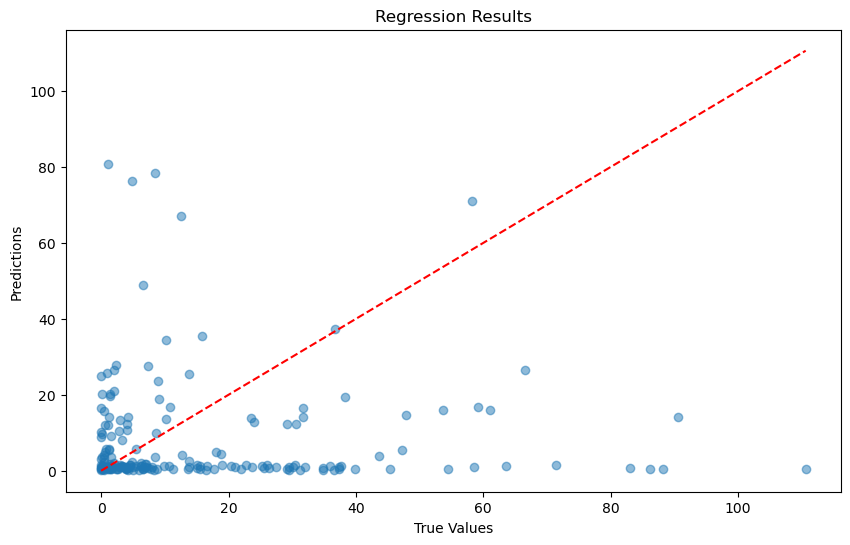

In [7]:
def plot_regression_results(model, dataloader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for batch in dataloader:
            x, y = batch
            y_hat = model(x)
            y_true.append(y)
            y_pred.append(y_hat)

    y_true = torch.cat(y_true).numpy()
    y_pred = torch.cat(y_pred).numpy()

    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.title('Regression Results')
    plt.show()
plot_regression_results(cancer_regressor, cancer_dm.test_dataloader())

In [8]:
import optuna

trial_to_details = {}
def objective(trial):
    # Sample hyperparameters
    activation_dict = {
        "relu": nn.ReLU,
        "leaky_relu": nn.LeakyReLU,
        "tanh": nn.Tanh,
        "RReLU": nn.RReLU,
    }
    optimizer_dict = {
        "adam": torch.optim.Adam,
        "sgd": torch.optim.SGD,
        "adagrad": torch.optim.Adagrad,
    }
    n_layers = trial.suggest_int("n_layers", 3, 10)
    dropout = trial.suggest_float("dropout", 0.0, 0.5)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-2, log=True)
    optimizer = trial.suggest_categorical("optimizer", list(optimizer_dict.keys()))
    activation = trial.suggest_categorical("activation", list(activation_dict.keys()) )

    activation = activation_dict[activation]
    optimizer = optimizer_dict[optimizer]

    model =NNRegressor(
        input_dim=len(cancer_dm.ds_train[0][0]),
        n_layers=n_layers,
        dropout=dropout,
        activation=activation,
        optimizer=optimizer,
        lr=learning_rate,
        weight_decay=weight_decay,
    )
    trainer, logger, checkpoint = create_classifier_trainer(f"nn_trial_{trial.number}", max_epochs=100, enable_pbar=False)


    # Training loop
    trainer.fit(
        model,
        datamodule=CancerDataModule(cancer_df, numerical_features=numeric_cols, scaler=scaler),
    )
    trial_to_details[trial.number] = {
        "logger" : logger,
        "checkpoint" : checkpoint,
    }

    
    # Store trial details
    trial_to_details[trial.number] = {
        "logger" : logger,
        "checkpoint" : checkpoint,
    }
    metrics_path = f"{logger.log_dir}/metrics.csv"
    metrics_df = pd.read_csv(metrics_path)

    if "val_mse" not in metrics_df.columns:
        return float("inf")

    last_val = metrics_df["val_mse"].dropna().values[-1]
    return last_val

In [ ]:
# --- Run Optuna ---
study = optuna.create_study(direction="minimize", study_name="regressor_study")
study.optimize(objective, n_trials=50, n_jobs=15, show_progress_bar=True)

# --- Print Best Result ---
print("Best trial:")
print(f"  Value (val_mse): {study.best_trial.value}")
print("  Params:")
for key, val in study.best_trial.params.items():
    print(f"    {key}: {val}")

[I 2025-04-14 20:30:04,802] A new study created in memory with name: regressor_study


  0%|          | 0/50 [00:00<?, ?it/s]

/uufs/chpc.utah.edu/common/home/clementm-group1/conda/mambaforge/env/bmi_6114/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /uufs/chpc.utah.edu/common/home/clementm-group1/cond ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/uufs/chpc.utah.edu/common/home/clementm-group1/conda/mambaforge/env/bmi_6114/lib/python3.12/site-packages/lightning/fabric/plugins/environme

[I 2025-04-14 20:37:53,755] Trial 3 finished with value: 1010.682373046875 and parameters: {'n_layers': 5, 'dropout': 0.18731908143563325, 'learning_rate': 0.0021556657196390556, 'weight_decay': 0.0013459588139465805, 'optimizer': 'adagrad', 'activation': 'tanh'}. Best is trial 3 with value: 1010.682373046875.


/uufs/chpc.utah.edu/common/home/clementm-group1/conda/mambaforge/env/bmi_6114/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /uufs/chpc.utah.edu/common/home/clementm-group1/cond ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | network     | Sequential       | 14.1 M | train
1 | loss_metric | MeanSquaredError | 0      | train
2 | val_metric  | MeanSquaredError | 0      | train
3 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
14.1 M    Trainable params
0         Non-trainable params
14.1 M    To

[I 2025-04-14 20:39:19,801] Trial 1 finished with value: 1025.0286865234375 and parameters: {'n_layers': 9, 'dropout': 0.008348955044921336, 'learning_rate': 0.0026002551780454765, 'weight_decay': 4.689409768588949e-05, 'optimizer': 'adagrad', 'activation': 'RReLU'}. Best is trial 3 with value: 1010.682373046875.


/uufs/chpc.utah.edu/common/home/clementm-group1/conda/mambaforge/env/bmi_6114/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /uufs/chpc.utah.edu/common/home/clementm-group1/cond ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | network     | Sequential       | 3.5 M  | train
1 | loss_metric | MeanSquaredError | 0      | train
2 | val_metric  | MeanSquaredError | 0      | train
3 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
3.5 M     Trainable params
0         Non-trainable params
3.5 M     To

[I 2025-04-14 20:43:30,667] Trial 15 finished with value: 1088.9866943359375 and parameters: {'n_layers': 9, 'dropout': 0.08599823917142557, 'learning_rate': 0.0003391433595764588, 'weight_decay': 0.003042239873705965, 'optimizer': 'sgd', 'activation': 'tanh'}. Best is trial 3 with value: 1010.682373046875.


/uufs/chpc.utah.edu/common/home/clementm-group1/conda/mambaforge/env/bmi_6114/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /uufs/chpc.utah.edu/common/home/clementm-group1/cond ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | network     | Sequential       | 850 K  | train
1 | loss_metric | MeanSquaredError | 0      | train
2 | val_metric  | MeanSquaredError | 0      | train
3 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
850 K     Trainable params
0         Non-trainable params
850 K     To

[I 2025-04-14 20:45:15,192] Trial 16 finished with value: 1032.2242431640625 and parameters: {'n_layers': 6, 'dropout': 0.42712253906080316, 'learning_rate': 0.0011912280063726512, 'weight_decay': 0.0037805402518752544, 'optimizer': 'adagrad', 'activation': 'tanh'}. Best is trial 3 with value: 1010.682373046875.


/uufs/chpc.utah.edu/common/home/clementm-group1/conda/mambaforge/env/bmi_6114/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /uufs/chpc.utah.edu/common/home/clementm-group1/cond ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | network     | Sequential       | 56.3 M | train
1 | loss_metric | MeanSquaredError | 0      | train
2 | val_metric  | MeanSquaredError | 0      | train
3 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
56.3 M    Trainable params
0         Non-trainable params
56.3 M    To

[I 2025-04-14 20:46:48,425] Trial 18 finished with value: 1030.72802734375 and parameters: {'n_layers': 10, 'dropout': 0.3580436570245329, 'learning_rate': 2.210583535644401e-05, 'weight_decay': 0.004303904533826736, 'optimizer': 'adagrad', 'activation': 'tanh'}. Best is trial 3 with value: 1010.682373046875.


/uufs/chpc.utah.edu/common/home/clementm-group1/conda/mambaforge/env/bmi_6114/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /uufs/chpc.utah.edu/common/home/clementm-group1/cond ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | network     | Sequential       | 56.3 M | train
1 | loss_metric | MeanSquaredError | 0      | train
2 | val_metric  | MeanSquaredError | 0      | train
3 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
56.3 M    Trainable params
0         Non-trainable params
56.3 M    To

[I 2025-04-14 20:50:37,508] Trial 19 finished with value: 1023.5596313476562 and parameters: {'n_layers': 10, 'dropout': 0.1866254336734826, 'learning_rate': 2.7368894980354797e-05, 'weight_decay': 1.2817919777128424e-05, 'optimizer': 'adagrad', 'activation': 'tanh'}. Best is trial 3 with value: 1010.682373046875.


/uufs/chpc.utah.edu/common/home/clementm-group1/conda/mambaforge/env/bmi_6114/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /uufs/chpc.utah.edu/common/home/clementm-group1/cond ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | network     | Sequential       | 3.5 M  | train
1 | loss_metric | MeanSquaredError | 0      | train
2 | val_metric  | MeanSquaredError | 0      | train
3 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
3.5 M     Trainable params
0         Non-trainable params
3.5 M     To

[I 2025-04-14 20:52:35,669] Trial 20 finished with value: 1029.855224609375 and parameters: {'n_layers': 7, 'dropout': 0.29256566639163695, 'learning_rate': 5.350197220090399e-05, 'weight_decay': 0.003312510833105968, 'optimizer': 'adagrad', 'activation': 'tanh'}. Best is trial 3 with value: 1010.682373046875.


/uufs/chpc.utah.edu/common/home/clementm-group1/conda/mambaforge/env/bmi_6114/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /uufs/chpc.utah.edu/common/home/clementm-group1/cond ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | network     | Sequential       | 829 K  | train
1 | loss_metric | MeanSquaredError | 0      | train
2 | val_metric  | MeanSquaredError | 0      | train
3 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
829 K     Trainable params
0         Non-trainable params
829 K     To

[I 2025-04-14 20:55:21,536] Trial 21 finished with value: 999.7816162109376 and parameters: {'n_layers': 4, 'dropout': 0.0830379704188951, 'learning_rate': 0.00043709818812943436, 'weight_decay': 0.00013518271063553056, 'optimizer': 'adagrad', 'activation': 'relu'}. Best is trial 21 with value: 999.7816162109376.


/uufs/chpc.utah.edu/common/home/clementm-group1/conda/mambaforge/env/bmi_6114/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /uufs/chpc.utah.edu/common/home/clementm-group1/cond ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | network     | Sequential       | 3.5 M  | train
1 | loss_metric | MeanSquaredError | 0      | train
2 | val_metric  | MeanSquaredError | 0      | train
3 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
3.5 M     Trainable params
0         Non-trainable params
3.5 M     To